<a href="https://colab.research.google.com/github/SalimZ04/UAV_MCV/blob/main/Model_vrp_UGV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 33.2 MB/s eta 0:00:00


In [2]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

In [6]:
# define VRP

n_customer = 9
n_point = n_customer + 1
vehicle_capacity = 8

df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
    'demand': np.random.randint(1, 5, n_point),
})

df.iloc[0]['x'] = 0 #Sélectionne la valeur dans la première ligne et la première colonne x
df.iloc[0]['y'] = 0 #Sélectionne la valeur dans la première ligne et la première colonne y
df.iloc[0]['demand'] = 0 # Sélectionne la valeur dans la première ligne et la première colonne demand

df

,x,y,demand
0,0,0,0
1,37,38,1
2,47,39,1
3,74,42,4
4,63,5,1
5,62,17,1
6,9,17,4
7,20,72,2
8,28,82,4
9,42,60,1


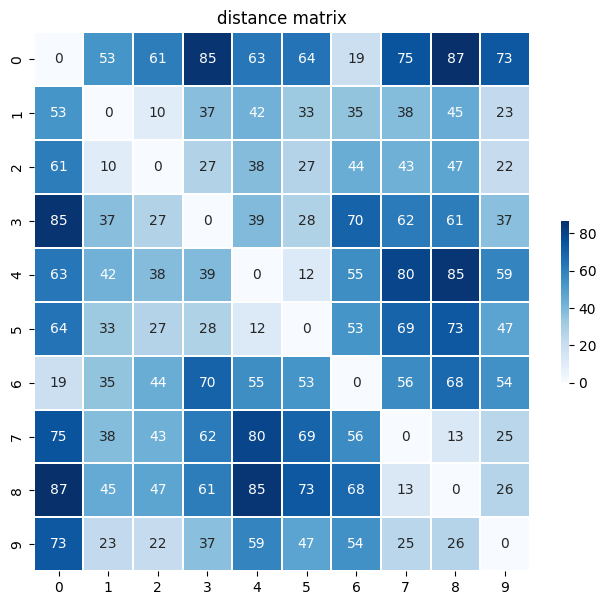

In [7]:
distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

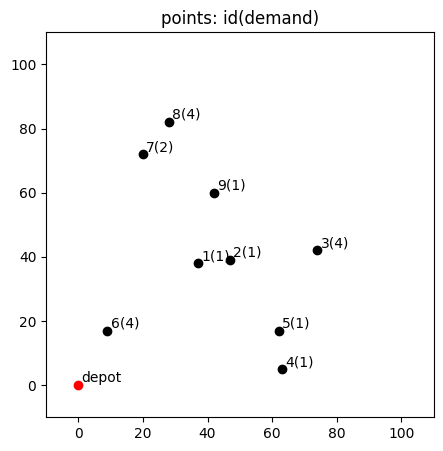

In [8]:
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

In [9]:
%%time

demands = df['demand'].values

# set problem
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

# set variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer')

# set objective function
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0
    
for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
        
problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle
problem += pulp.lpSum(x[0, i] for i in range(n_point)) == n_vehicle

# eliminate subtour
subtours = []
for length in range(2, n_point):
     subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

# solve problem
status = problem.solve()

# output status, value of objective function
status, pulp.LpStatus[status], pulp.value(problem.objective)

CPU times: user 131 ms, sys: 4.79 ms, total: 136 ms
Wall time: 470 ms


(1, 'Optimal', 418.5436252065527)

In [10]:
pulp.value(n_vehicle)

3.0

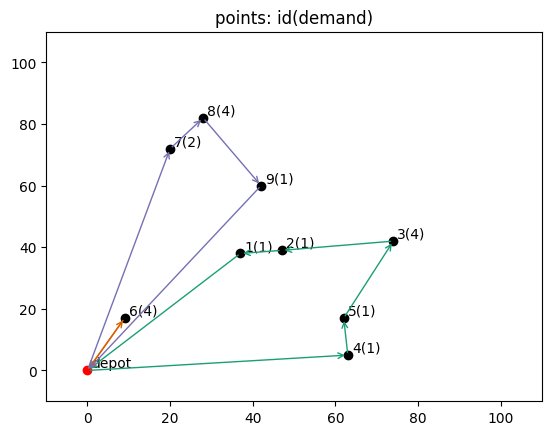

In [11]:
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')

# draw optimal route
cmap = matplotlib.cm.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    
    # identify the route of each vehicle
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    # draw for each vehicle
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()